In [1]:
import glob
from itertools import chain
import os
import sys
import time
import random
import zipfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import librosa
import torch
import torch.nn as nn
import torchaudio.functional as F
import torchaudio.transforms as T
import torch.optim as optim
import torchaudio
import IPython.display as ipd

from tqdm import tqdm
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from tabulate import tabulate
from IPython.display import Audio

from collections import defaultdict

from torch.autograd import Variable
from torch.utils.data import Dataset
from scipy.io.wavfile import read

from linformer_pytorch import Linformer
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import ConcatDataset, DataLoader, Dataset
from torchvision import datasets, transforms
import tqdm
import IPython.display

from tqdm.notebook import tqdm

from torch.nn.utils.rnn import pad_sequence

In [2]:
!nvidia-smi

Wed Mar  8 19:07:57 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
| N/A   54C    P8    N/A /  N/A |    458MiB /  4042MiB |     25%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
class SpeechCommandsDataset(Dataset):
    """Google Speech Commands dataset."""

    def __init__(self, root_dir, split,transform=None):
        """
        Args:
            root_dir (string): Directory with all the data files.
            split    (string): In ["train", "valid", "test"].
        """
        self.root_dir = root_dir
        self.split = split
        self.transform = transform

        self.number_of_classes = len(self.get_classes())

        self.class_to_file = defaultdict(list)

        self.valid_filenames = self.get_valid_filenames()
        self.test_filenames = self.get_test_filenames()

        for c in self.get_classes():
            file_name_list = sorted(os.listdir(self.root_dir + "dataset/" + c))
            for filename in file_name_list:
                if split == "train":
                    if (filename not in self.valid_filenames[c]) and (filename not in self.test_filenames[c]):
                        self.class_to_file[c].append(filename)
                elif split == "valid":
                    if filename in self.valid_filenames[c]:
                        self.class_to_file[c].append(filename)
                elif split == "test":
                    if filename in self.test_filenames[c]:
                        self.class_to_file[c].append(filename)
                else:
                    raise ValueError("Invalid split name.")

        self.filepath_list = list()
        self.label_list = list()
        for cc, c in enumerate(self.get_classes()):
            f_extension = sorted(list(self.class_to_file[c]))
            l_extension = [cc for i in f_extension]
            f_extension = [self.root_dir + "dataset/" + c + "/" + filename for filename in f_extension]
            self.filepath_list.extend(f_extension)
            self.label_list.extend(l_extension)
        self.number_of_samples = len(self.filepath_list)
    def __len__(self):
        return self.number_of_samples

    def __getitem__(self, idx):
        sample = np.zeros((16000, ), dtype=np.float32)

        sample_file = self.filepath_list[idx]

        sample_from_file = read(sample_file)[1]
        sample[:sample_from_file.size] = sample_from_file
        sample = sample.reshape((16000, ))
        
        # It is better to stick to PyTorch functions
        # I swapped the `librose´ mfcc resampling with this PyTorch alternative
        # however, the parameters are the same
        mfcc_transform = T.MFCC(
            sample_rate=16000,
            n_mfcc=20,
            melkwargs={
              'n_fft': 2048,
              'hop_length': 512})
        
        #print(f">> Sample Shape: {sample.shape}")
        
        sample = torch.transpose(mfcc_transform(torch.tensor(sample)), 0, 1)
        
        #sample = librosa.feature.mfcc(y=sample, sr=16000, hop_length=512, n_fft=2048).transpose().astype(np.float32)
        
        # we apply the augmentations on the sample if it is defined
        if self.transform:
            sample = self.transform(samples=sample.reshape(32, 1, 20), sample_rate=16000)
            sample = sample.reshape(32, 20)
        
        #print(f">> Sample Shape: {sample.shape}")
        #print("--"*10)

        label = self.label_list[idx]

        return sample, label

    def get_classes(self):
        return ["yes", "no", "up", "down", "left", "right", "enable", "stop", "start", "backward", "cancel", "close", "rotate", "digit", "direction", "disable", 
        "zoom in","zoom out","undo","enter","forward","move","next","record","receive","previous"]

    def get_valid_filenames(self):
        class_names = self.get_classes()

        class_to_filename = defaultdict(set)
        with open(self.root_dir + "dataset/val.txt", "r") as fp:
            for line in fp:
                clean_line = line.strip().split("/")

                if clean_line[0] in class_names:
                    class_to_filename[clean_line[0]].add(clean_line[1])

        return class_to_filename

    def get_test_filenames(self):
        class_names = self.get_classes()

        class_to_filename = defaultdict(set)
        with open(self.root_dir + "dataset/test.txt", "r") as fp:
            for line in fp:
                clean_line = line.strip().split("/")

                if clean_line[0] in class_names:
                    class_to_filename[clean_line[0]].add(clean_line[1])

        return class_to_filename

In [5]:
from torch_audiomentations import Compose, Gain, PolarityInversion

# Initialize augmentation callable
train_transforms = Compose(
    transforms=[
        Gain(
            min_gain_in_db=-15.0,
            max_gain_in_db=5.0,
            p=0.5,
        ),
        PolarityInversion(p=0.5)
    ]
)
val_transforms = Compose(
    transforms=[
        Gain(
            min_gain_in_db=-15.0,
            max_gain_in_db=5.0,
            p=0.5,
        ),
        PolarityInversion(p=0.5)
    ]
)
test_transforms = Compose(
    transforms=[
        Gain(
            min_gain_in_db=-15.0,
            max_gain_in_db=5.0,
            p=0.5,
        ),
        PolarityInversion(p=0.5)
    ]
)


In [6]:
dataset_folder="Arabic_Speech_command/"

train_dataset = SpeechCommandsDataset(dataset_folder, "train")

valid_dataset = SpeechCommandsDataset(dataset_folder, "valid")

test_dataset = SpeechCommandsDataset(dataset_folder, "test")

### Augmented Datasets ###
# Note we should concatenate both the non-augmented and the augmented training datasets

train_dataset_aug = ConcatDataset([SpeechCommandsDataset(dataset_folder, "train", transform=train_transforms),
                                  train_dataset])

valid_dataset_aug = SpeechCommandsDataset(dataset_folder, "valid", transform=val_transforms)

test_dataset_aug  = SpeechCommandsDataset(dataset_folder, "test", transform=test_transforms)

In [7]:
batch_size = 128

train_loader = DataLoader(dataset=train_dataset,
                           batch_size=batch_size,
                           shuffle=True)

valid_loader = DataLoader(dataset=valid_dataset,
                           batch_size=batch_size,
                           shuffle=True)

test_loader  = DataLoader(dataset=test_dataset,
                           batch_size=batch_size,
                           shuffle=True)

### Augmented Dataloaders + non-augmented ###

train_loader_aug = DataLoader(dataset=train_dataset_aug,
                           batch_size=batch_size,
                           shuffle=True)

valid_loader_aug = DataLoader(dataset=valid_dataset_aug,
                           batch_size=batch_size,
                           shuffle=True)

test_loader_aug  = DataLoader(dataset=test_dataset_aug,
                           batch_size=batch_size,
                           shuffle=True)

In [8]:
print(f"Training dataset -- dataloader lengths: {len(train_dataset)} -- {len(train_loader)}")

print(f"Validation dataset -- dataloader lengths: {len(valid_dataset)} -- {len(valid_loader)}")

print(f"Testing dataset -- dataloader lengths: {len(test_dataset)} -- {len(test_loader)}")

Training dataset -- dataloader lengths: 4681 -- 37
Validation dataset -- dataloader lengths: 1559 -- 13
Testing dataset -- dataloader lengths: 1560 -- 13


In [9]:
class NeuralNetworkModel(nn.Module):
    """Neural network model (Transformer-based).

    Args:
        idim (int): Input feature dimension.
        d_att (int): Attention dimension.
        n_heads (int): The number of attention heads.
        d_ff (int): Dimension of feed forward network.
        dropout_rate (float): Dropout rate.
        n_layers (int): The number of encoder layers.
        d_linear (int): Dimension of a hidden layer of the classifier.
        n_classes (int): The number of the output classes.

    """

    def __init__(
        self,
        idim=13,
        d_att=64,
        n_heads=2,
        d_ff=512,
        dropout_rate=0.1,
        n_layers=3,
        n_classes=40
    ):
        super().__init__()
        self.subsampling = Subsampling(idim=idim, d_att=d_att)
        self.positional_encoding = PositionalEncoding()
        self.encoder_layers = nn.Sequential()
        for i in range(n_layers):
            self.encoder_layers.add_module(
                f'EncoderLayer{i}', 
                TransformerEncoderLayer(d_att, n_heads, d_ff, dropout_rate)
            )
        self.norm = nn.LayerNorm(d_att)
        self.dropout = nn.Dropout(dropout_rate)
        self.out = nn.Linear(d_att, n_classes)

    def forward(self, x):
        """Recognize the input speech commands.

        Args:
            x (torch.Tensor): Input features (batch, tmax, idim).

        Returns:
            torch.Tensor: Recognized classes (batch, num_classes).

        """   
        # Transformer encoder
        x = self.subsampling(x)
        x = self.positional_encoding(x)
        x = self.encoder_layers(x)
        x = self.norm(x)
        # Classifier
        x = torch.mean(x, dim=1)  # (b, t, d_att) -> (b, d_att)
        x = self.dropout(x)
        x = self.out(x)

        return x

class TransformerEncoderLayer(nn.Module):
    """A Transformer encoder layer.

    Args:
        d_att (int): Attention dimension.
        d_head (int): The number of attention heads.
        d_ff (int): Dimension of feed forward network.
        dropout_rate (float): Dropout rate.

    """

    def __init__(self, d_att, d_head, d_ff, dropout_rate=0.1):
        super().__init__()
        self.mha = MultiHeadAttention(d_att, d_head, dropout_rate)
        self.ff = FeedForward(d_att, d_ff, dropout_rate)
        self.norm_mha = nn.LayerNorm(d_att)
        self.norm_ff = nn.LayerNorm(d_att)
        self.dropout = nn.Dropout(dropout_rate)
    
    def forward(self, x):
        """

        Args:
            x (torch.Tensor): Pre-encoded inputs (batch, tmax, d_att).

        Returns:
            torch.Tensor: Encoded outputs (batch, tmax, d_att).

        """
        # Multi-Head Attention
        res = x
        x = self.norm_mha(x)
        x = res + self.dropout(self.mha(x, x, x))

        # Feed-Forward
        res = x
        x = self.norm_ff(x)
        x = res + self.dropout(self.ff(x))

        return x
class Subsampling(nn.Module):
    """Convolutional Subsampling.

    Args:
        idim (int): Input feature dimension.
        d_att (int): Attention dimension.

    """

    def __init__(self, idim, d_att):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, d_att, kernel_size=(3, 3), stride=(2, 2)),
            nn.ReLU(),
            nn.Conv2d(d_att, d_att, kernel_size=(3, 3), stride=(2, 2)),
            nn.ReLU(),
        )
        self.linear = nn.Linear(256, d_att)

    def forward(self, x):
        """

        Args:
            x (torch.Tensor): Input features (batch, tmax, idim).

        Returns:
            torch.Tensor: Subsampled features (batch, tmax', d_att).

        """
        x = x.unsqueeze(1)  # (b, t, idim) -> (b, c=1, t, idim)
        x = self.conv(x)
        b, c, t, f = x.size()
        #x = x.view(x.size(0), -1)
        x = x.transpose(1, 2).contiguous().view(b, t, c * f)  # (b, c, t, f) -> (b, t, c * t)
        
        x = self.linear(x)

        return x

class PositionalEncoding(nn.Module):
    """Positional Encoding.

    Args:
        idim (int): Input feature dimension.

    """

    def __init__(self):
           super().__init__()
        
    def forward(self, x):
        """

        Args:
            x: (torch.Tensor): Subsampled features (batch, tmax, d_att).

        Returns:
            torch.Tensor: Encoded features (batch, tmax, d_att).

        """
        _, tmax, d_att = x.size()
        pos = torch.arange(0, tmax, dtype=torch.float32).unsqueeze(1)
        pe = torch.zeros(1, tmax, d_att, dtype=torch.float32).to(x.device)
        pe[:, :, 0::2] = torch.sin(pos / torch.pow(10000, torch.arange(0, d_att, 2) / d_att))
        pe[:, :, 1::2] = torch.cos(pos / torch.pow(10000, torch.arange(0, d_att, 2) / d_att))
        x = x + pe

        return x

class MultiHeadAttention(nn.Module):
    """Multi-Head Attention.

    Args:
        d_att (int): Dimension of attention.
        d_head (int): The number of attention heads.
        dropout_rate (float): Dropout rate.

    """

    def __init__(self, d_att, n_heads, dropout_rate):
        super().__init__()
        self.linear_q = nn.Linear(d_att, d_att)
        self.linear_k = nn.Linear(d_att, d_att)
        self.linear_v = nn.Linear(d_att, d_att)
        self.linear_head = nn.Linear(d_att, d_att)
        self.dropout = nn.Dropout(dropout_rate)
        self.n_heads = n_heads
        self.d_comn = d_att // self.n_heads

    def forward(self, q, k, v):
        """

        Args:
            q: (torch.Tensor): Query (batch, tmax, d_att).
            k: (torch.Tensor): Key (batch, tmax, d_att).
            v: (torch.Tensor): Value (batch, tmax, d_att).
            Returns:
            torch.Tensor: Output shape (batch, tmax, d_att).

        """
        # Linear
        qw = self.linear_q(q)
        kw = self.linear_k(k)
        vw = self.linear_v(v)

        # Reshape tensor (b, t, d_att) -> (b, n_heads, t, d_comn)
        b, t, d_att = q.size()
        qw = qw.view(b, t, self.n_heads, self.d_comn).transpose(1, 2)
        kw = kw.view(b, t, self.n_heads, self.d_comn).transpose(1, 2)
        vw = vw.view(b, t, self.n_heads, self.d_comn).transpose(1, 2)

        # Dot-attention
        matmul = torch.matmul(qw, kw.transpose(2, 3)) 
        scale = matmul / torch.sqrt(torch.tensor(self.d_comn))
        softmax = torch.softmax(scale, dim=-1)
        att = torch.matmul(self.dropout(softmax), vw)  # (b, n_heads, t, d_comn)

        # Concatenate
        att = att.transpose(1, 2).contiguous().view(b, -1, self.n_heads * self.d_comn)  # (b, t, d_att)

        # Linear
        mha = self.linear_head(att)

        return mha

class FeedForward(nn.Module):
    """Feed-Forward Network.

    Args:
        d_ff (int): Dimension of feed-forward network.

    """

    def __init__(self, d_att, d_ff, dropout_rate):
        super().__init__()
        self.ff = nn.Sequential(
            nn.Linear(d_att, d_ff), nn.ReLU(), nn.Dropout(dropout_rate), nn.Linear(d_ff, d_att)
        )

    def forward(self, x):
        """

        Args:
            x: (torch.Tensor): Input shape (batch, tmax, d_att).

        Returns:
            torch.Tensor: Output shape (batch, tmax, d_att).

        """
        return self.ff(x)

In [17]:
# define some metric lists
def train(model, optimizer, train_loader, valid_loader, 
          criterion, results_dir='result', epochs=5, plot=False):
    
    #store evaluation metrics in these lists
    train_acc_list = []
    train_loss_list = []
    dev_acc_list = []
    dev_loss_list = []
    
    # best loss tracking for model checkpointing
    best_loss = float("inf")

    # Train the model
    training_start_time = time.time()
    for epoch in range(epochs):

        batch_train_loss = 0
        batch_train_acc = 0
        batch_dev_loss = 0
        batch_dev_acc = 0

        # Training
        model.train()
        for feats, labels in train_loader:
            feats, labels = feats.to(device), labels.to(device)

            # Reset gradients
            optimizer.zero_grad()

            # Forward
            outputs = model(feats)
            loss = criterion(outputs, labels)

            # Backward
            loss.backward()

            # Update weights
            optimizer.step()

            batch_train_loss += loss.item()
            batch_train_acc += (outputs.max(1)[1] == labels).sum().item()

        train_loss_list.append(batch_train_loss / len(train_loader))
        train_acc_list.append(batch_train_acc / len(train_loader.dataset))
        # Validation
        
        model.eval()
        with torch.no_grad():
            for feats, labels in valid_loader:
                feats, labels = feats.to(device), labels.to(device)

                # Forward
                outputs = model(feats)
                loss = criterion(outputs, labels)

                batch_dev_loss += loss.item()
                batch_dev_acc += (outputs.max(1)[1] == labels).sum().item()

        dev_loss_list.append(batch_dev_loss / len(valid_loader))
        dev_acc_list.append(batch_dev_acc / len(valid_loader.dataset))

        # Save the best model
        if best_loss > dev_loss_list[-1]:
            torch.save(model.state_dict(), "result/model_best_loss.pth")
            best_loss = dev_loss_list[-1]
            
        ipd.clear_output()

        # Print statistics
        print(
            "Epoch: {}/{} - train_loss: {:.4f} - train_acc: {:.4f} - dev_loss: {:.4f} - dev_acc: {:.4f}".format(
                epoch+1, epochs, train_loss_list[-1], train_acc_list[-1], dev_loss_list[-1], dev_acc_list[-1]
            )
        )
        
        # # plot results if flag is True
        if plot:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 6.5))

            ax[0].plot(range(len(train_loss_list)), train_loss_list, label='train loss')
            ax[0].plot(range(len(dev_loss_list)), dev_loss_list, label='val loss')
            ax[0].set_title('Loss Evolution')

            ax[1].plot(range(len(train_acc_list)), train_acc_list, label='train accuracy')
            ax[1].plot(range(len(dev_acc_list)), dev_acc_list, label='val accuracy')
            ax[1].set_title('Accuracy Evolution')

            ax[0].legend()
            ax[1].legend()

            plt.show()

    # Save the training time
    training_time = time.time() - training_start_time
    print(f">> Training Time: {training_time}")
    # Make a directory to save the results
    os.makedirs("result", exist_ok=True)
    with open("result/training_time.txt", "w") as time_f:
        time_f.write(f"training time = {int(training_time)} (sec)\n")
        
def test(model, test_loader, criterion, plot=False):
    best_loss = float("inf")

    # Test
    test_start_time = time.time()
    
    batch_test_loss = 0
    batch_test_acc = 0

    model.eval()
    with torch.no_grad():
        for feats, labels in test_loader:
            feats, labels = feats.to(device), labels.to(device)

            # Forward
            outputs = model(feats)
            loss = criterion(outputs, labels)

            batch_test_loss += loss.item()
            batch_test_acc += (outputs.max(1)[1] == labels).sum().item()

    test_mean_loss = batch_test_loss / len(test_loader.dataset)
    test_mean_acc = batch_test_acc / len(test_loader.dataset)

    # Print statistics
    print(
        "test_loss: {:.4f} - test_acc: {:.4f}".format(
            test_mean_loss, test_mean_acc
        )
    )

    # Print out test time
    test_time = time.time() - test_start_time
    print(f">> Test Time: {test_time}")

# Train/Validation Runs

Epoch: 50/50 - train_loss: 0.0037 - train_acc: 1.0000 - dev_loss: 5.3312 - dev_acc: 0.0539


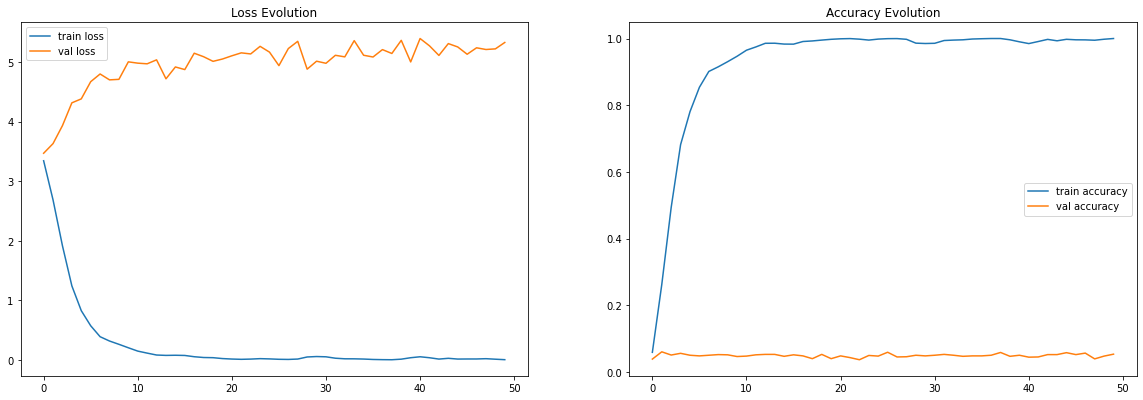

>> Training Time: 480.28048157691956


In [11]:
## Train Data (non-augmented) with Validation Data (Augmented)
# We can notice that the validation accuracy stays low at a value of ~ 0.06 
# On the other hand, the validation loss increases and reaches a value of +5.33

# Build a model
model = NeuralNetworkModel().to(device)
print(f"# model parameters: {sum(p.numel() for p in model.parameters()):,}")

# Define an optimizer and a loss function
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
loss_fn = nn.CrossEntropyLoss()

epochs = 50

train(model=model, optimizer=optimizer, 
      train_loader=train_loader, valid_loader=valid_loader_aug, 
      criterion=loss_fn, epochs=epochs, plot=True)

Epoch: 50/50 - train_loss: 0.0384 - train_acc: 0.9893 - dev_loss: 1.2369 - dev_acc: 0.7479


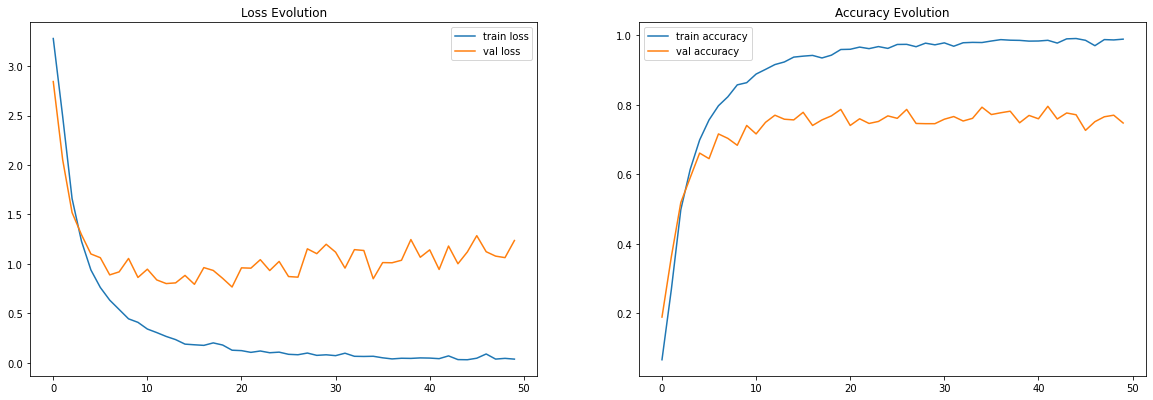

>> Training Time: 989.7576668262482


In [12]:
## Train Data (augmented) with Validation Data (non-Augmented)
# We can notice that the max validation accuracy reaches a value of +80%

# Build a model
model = NeuralNetworkModel().to(device)
print(f"# model parameters: {sum(p.numel() for p in model.parameters()):,}")

# Define an optimizer and a loss function
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
loss_fn = nn.CrossEntropyLoss()

epochs = 50

train(model=model, optimizer=optimizer, 
      train_loader=train_loader_aug, valid_loader=valid_loader, 
      criterion=loss_fn, epochs=epochs, plot=True)

Epoch: 50/50 - train_loss: 0.0345 - train_acc: 0.9881 - dev_loss: 1.2371 - dev_acc: 0.7441


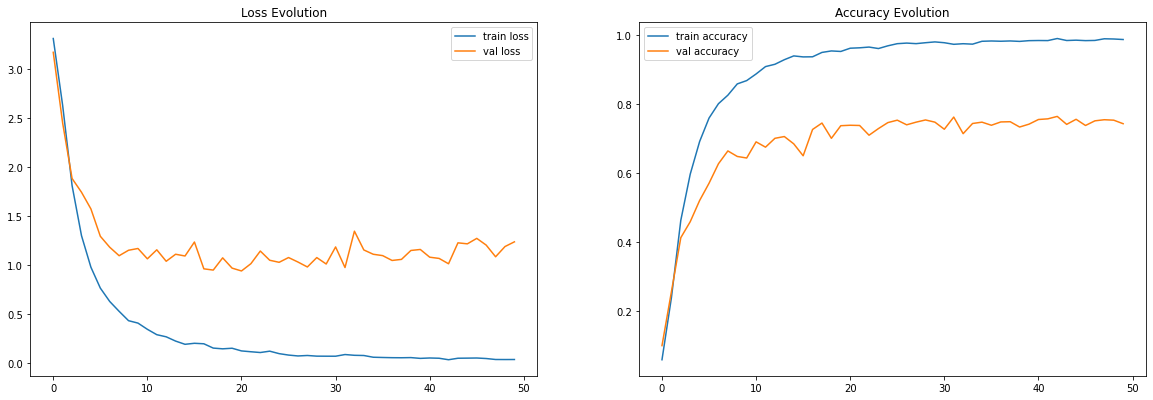

>> Training Time: 1057.770741701126


In [13]:
## Train Data (augmented) with Validation Data (Augmented)
# We can notice that the max accuracy is reaching a value of ~ 77%

# Build a model
model = NeuralNetworkModel().to(device)
print(f"# model parameters: {sum(p.numel() for p in model.parameters()):,}")

# Define an optimizer and a loss function
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
loss_fn = nn.CrossEntropyLoss()

epochs = 50

train(model=model, optimizer=optimizer, 
      train_loader=train_loader_aug, valid_loader=valid_loader_aug, 
      criterion=loss_fn, epochs=epochs, plot=True)

# Test Runs

In [18]:
## Testing the model with the test augmented data

test(model=model, test_loader=test_loader_aug, criterion=loss_fn)

test_loss: 0.0104 - test_acc: 0.7301
>> Test Time: 2.7721316814422607


In [19]:
## Testing the model with the test non-augmented data

test(model=model, test_loader=test_loader, criterion=loss_fn)

test_loss: 0.0089 - test_acc: 0.7679
>> Test Time: 1.7516155242919922
